In [132]:
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from numpy.random import rand
import collections
import datetime
import dateutil.parser

In [245]:
import pandas as pd
# params
actions = 6
# deposit, borrow, repay, liquidate, repay, flashLoan, others
# 0xd2d0e066, 0xc858f5f9, 0x5ceae9c4, 0x00a718a9, 0x5cffe9de, ...

rewards = {
    "0xd2d0e066": 3,
    "0xc858f5f9": 25,
    "0x5ceae9c4": -15,
    "0x00a718a9": -20,
    "0x5cffe9de": 3
}

actionReward = [3, 13, -1, -20, 2, 0]
regularActionDistribution = [0.561, 0.257, 0.156, 0.015, 0.02]
crisisActionDistribution = [0.479, 0.106, 0.321, 0.086, 0]

layers = 5
layerScore = [0, 10, 20, 29, 37]
layerDiscount = [0, 0.033, 0.066, 0.1, 0.133]

layerCurationInterval = 3900
actionsToCurateLBCR = 70
# interactionFrequencyPerBlock = 0.00014
interactionFrequencyPerBlock = 0.07875
interactionFrequencyPerBlock = 1.2675

# aave 1.25 days

aave_txs = pd.read_csv("aave.csv")
aave_txs.sort_values(by=['dateyear', 'datemonth', 'dateday', 'datehour', 'dateminute'])

ethdaiprice = pd.read_csv("ethdaiprice.csv")

In [26]:
# use totalCount/(30*4*users) with rand() to decide if user acts

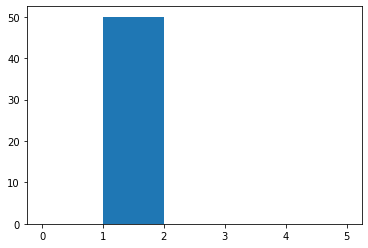

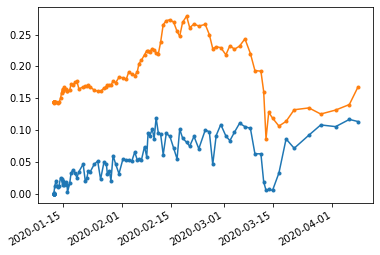

22.136530612244897
1.553061224489796
0.06590054794520547
98


In [248]:
def movingAverage(list):
    windowSize = 10
    length = min(len(list), windowSize)
    if not length:
        return 0
    return sum(list[:-length]) / length

def curate():
#     print(userScore)
    for user in range(users):
        layer = 0
        userScoreOverTime[user].append(userScore[user])
        
        while layer + 1 < layers and userScore[user] >= layerScore[layer + 1]:
            layer += 1
        userLayers[user] = layer
#         print(user,layer,userLayers[user])
#         if layer < userLayers[user]:
#             userLayers[user] -= 1
#         elif layer > userLayers[user]:
#             userLayers[user] += 1
#         print(userScore[user], userLayers[user])
        userScore[user] = 0
        layerPositions[user].append(userLayers[user])
        layerDiscounts[user].append(layerDiscount[userLayers[user]])
        
#         if not layerDiscounts[user]:
#             layerDiscounts[user].append(layerDiscount[userLayers[user]])
#         else:
#             layerDiscounts[user].append(layerDiscount[userLayers[user]] * 0.5 + 0.5 * layerDiscounts[user][-1])
            
        
    
def drawActionFromDistribution(actionCounts, totalCount):
    randomDraw = rand()
    sum = 0
#     print(randomDraw, actionCounts, totalCount)
    for (key, actionCount) in actionCounts.items():
        sum += actionCount / totalCount
#         print(sum)
#         sum += regularActionDistribution[i]
#         sum += crisisActionDistribution[i]
        if randomDraw < sum:
            return key
    return None

def avg(l):
    return sum(l)/len(l)
            

users = 50
userScore = [0] * users
userLayers = [0] * users

layerDiscountSum = [0] * users

T = 5000000 # interval of running the simulation

layerPositions = [[] for _ in range(users)]
layerDiscounts = [[] for _ in range(users)]
userScoreOverTime = [[] for _ in range(users)]

curationDates = []
pricesAtCuration = []

actionsPerformed = []
actionsPerformedLastRound = 0

iterations = -1
priceFeedIndex = 0
i = 330
# i = 1600
# i = -1
while i + 1 < len(aave_txs):
# while i + 1 < len(aave_txs) and i < 4100:
    i += 1
    iterations += 1
#     print(dateutil.parser.parse(ethdaiprice.iloc[iterations].time))
#     dateFormat = [aave_txs.iloc[iterations].dateyear, aave_txs.iloc[iterations].datemonth, aave_txs.iloc[iterations].dateday, aave_txs.iloc[iterations].datehour, str(int(aave_txs.iloc[iterations].dateminute) * 30), '00']
#     newDate = datetime.datetime(*map(int, dateFormat))
#     print(newDate)
    counts = collections.defaultdict(int)
    totalCount = 0
    tx = aave_txs.iloc[i]
    counts[tx.f0_] = tx.f1_
    totalCount += tx.f1_
    while i + 1 < len(aave_txs) and tx.dateyear == aave_txs.iloc[i + 1].dateyear and \
        tx.datemonth == aave_txs.iloc[i + 1].datemonth and \
        tx.dateday == aave_txs.iloc[i + 1].dateday and \
        tx.datehour == aave_txs.iloc[i + 1].datehour and \
        tx.dateminute == aave_txs.iloc[i + 1].dateminute:

        tx = aave_txs.iloc[i]
        counts[tx.f0_] += tx.f1_
        totalCount += tx.f1_
        i += 1
    
    for j in range(30 * 4):
        # iterate 80 time (30 minutes, 4 blocks each minute)
#         print(actionsPerformedThisRound, actionsToCurateLBCR)
        
        for user in range(users):
            if rand() <= totalCount / (30 * 4 * users):
                action = drawActionFromDistribution(counts, totalCount)
#                 print(action in rewards)
                if action in rewards:
#                     print(rewards[action])
                    userScore[user] += rewards[action]
#                     print(userScore, actionsPerformedThisRound)
                layerDiscountSum[user] += layerDiscount[userLayers[user]]
                actionsPerformedThisRound += 1
#                 print("actionsPerformedThisRound", actionsPerformedThisRound, actionsToCurateLBCR)
            
#                 if actionsPerformedThisRound >= actionsToCurateLBCR:
                if (i * 30 * 4) / layerCurationInterval >= len(curationDates) * (movingAverage(actionsPerformed) / actionsPerformedThisRound):
#                 if (i * 30 * 4) / layerCurationInterval >= len(curationDates):
                    curate()
                    dateFormat = [tx.dateyear, tx.datemonth, tx.dateday, tx.datehour, str(int(tx.dateminute) * 30), '00']
                    curationDate = datetime.datetime(*map(int, dateFormat))
                    curationDates.append(curationDate)
                    actionsPerformed.append(actionsPerformedThisRound)
                    actionsPerformedThisRound = 0
                    
                    while priceFeedIndex < len(ethdaiprice) and dateutil.parser.parse(ethdaiprice.iloc[priceFeedIndex].time, ignoretz=True) < curationDate:
                        priceFeedIndex += 1
                    pricesAtCuration.append(ethdaiprice.iloc[priceFeedIndex].close / 1000)
#                     print("curated", actionsPerformedThisRound)
        
# for t in range(T):
#     if t % layerCurationInterval == 0:
#         curate()
#     for user in range(users):
#         if rand() <= interactionFrequencyPerBlock:
#             action = drawActionFromDistribution()
# #             print(action)
#             userScore[user] += actionReward[action]
#             layerDiscountSum[user] += layerDiscount[userLayers[user]]
#             actionsPerformedThisRound += 1
        
# for user in range(users):
#     print(f'user: {user} average layer po')
    
# print(layerPositions)
avgScores = []
avgLayers = []
avgReduction = []
for i in range(len(layerPositions)):
#     print(layerPosition)
#     print(avg(userScoreOverTime[i]))
    avgLayers.append(avg(layerPositions[i]))
    avgScores.append(avg(userScoreOverTime[i]))
#     avgReduction.append(avg(layerDiscounts[i]))
    
for i in range(len(layerDiscounts[0])):
    discounts = []
    for user in range(users):
        discounts.append(layerDiscounts[user][i])
    avgReduction.append(avg(discounts))
#     plt.plot(layerPosition)
    
# print(layerPositions[0])
plt.hist(np.array(avgLayers), bins=[0,1,2,3,4,5])

plt.figure()
# plt.scatter(curationDates, avgReduction)
# plt.scatter(curationDates, pricesAtCuration)
# plt.xlim(min(curationDates), max(curationDates))
# plt.gcf().autofmt_xdate()
plt.plot(curationDates, avgReduction, '.-')
plt.plot(curationDates, pricesAtCuration, '.-')
plt.gcf().autofmt_xdate()
plt.show()
print(avg(avgScores))
print(avg(avgLayers))
print(avg(avgReduction[25:]))
# print(iterations)
# print(len(curationDates))
print(len(avgReduction))
# print(len(pricesAtCuration))
# print(pricesAtCuration)


# np.histogram(np.array(layerPositions[0]))
# unique, counts = np.unique(np.array(avgLayers), return_counts=True)
# plt.bar(layerPosition[0])
# dict(zip(unique, counts))
        
# crisis:
#3.4137931034482754
# 0.48793103448275865
# 0.01611379310344828

# regular
# 21.570689655172416
# 2.2
# 0.07302068965517242

# 17.07909090909091
# 1.5499999999999998
# 0.07072195121951218



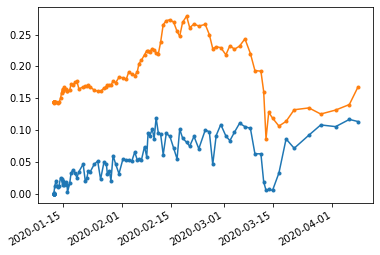

regular reduction 0.08089473684210524
crisis reduction 0.02828000000000001


In [269]:
plt.plot(curationDates, avgReduction, '.-')
plt.plot(curationDates, pricesAtCuration, '.-')
plt.gcf().autofmt_xdate()
plt.show()
# print(avg(avgScores))
# print(avg(avgLayers))
# print(avg(avgReduction))
print("regular reduction", avg(avgReduction[45:-15]))
print("crisis reduction", avg(avgReduction[-14:-7]))